<a href="https://colab.research.google.com/github/rishikakapoor/Malaria_dataset/blob/master/CodeTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 15kB/s 
     |████████████████████████████████| 450kB 27.5MB/s 
     |████████████████████████████████| 3.8MB 24.9MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [2]:
! git clone https://github.com/rishikakapoor/Malaria_dataset.git

Cloning into 'Malaria_dataset'...
remote: Enumerating objects: 27566, done.
remote: Total 27566 (delta 0), reused 0 (delta 0), pack-reused 27566
Receiving objects: 100% (27566/27566), 331.62 MiB | 57.15 MiB/s, done.
Checking out files: 100% (27559/27559), done.


In [3]:
! ls

Malaria_dataset  sample_data


In [1]:
import os
import glob

base_dir = os.path.join('/content/Malaria_dataset/Malaria_dataset')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13778, 13779)

[link text](https://)

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/Malaria_dataset/Malaria_dataset/Paras...,malaria
1,/content/Malaria_dataset/Malaria_dataset/Uninf...,healthy
2,/content/Malaria_dataset/Malaria_dataset/Uninf...,healthy
3,/content/Malaria_dataset/Malaria_dataset/Uninf...,healthy
4,/content/Malaria_dataset/Malaria_dataset/Uninf...,healthy


In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17360,) (1929,) (8268,)
Train: Counter({'healthy': 8707, 'malaria': 8653}) 
Val: Counter({'malaria': 1001, 'healthy': 928}) 
Test: Counter({'healthy': 4144, 'malaria': 4124})


In [4]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_4: working on img num: 5000
ThreadPoolExecutor-0_13: working on img num: 10000
ThreadPoolExecutor-0_17: working on img num: 15000
ThreadPoolExecutor-0_12: working on img num: 17359
Min Dimensions: [40 55  3]
Avg Dimensions: [132.94297235 132.53738479   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [346 394   3]


In [5]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_19: working on img num: 5000
ThreadPoolExecutor-1_12: working on img num: 10000
ThreadPoolExecutor-1_9: working on img num: 15000
ThreadPoolExecutor-1_13: working on img num: 17359

Loading Validation Images:
ThreadPoolExecutor-1_2: working on img num: 0
ThreadPoolExecutor-1_18: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-1_11: working on img num: 0
ThreadPoolExecutor-1_17: working on img num: 5000
ThreadPoolExecutor-1_11: working on img num: 8267


((17360, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

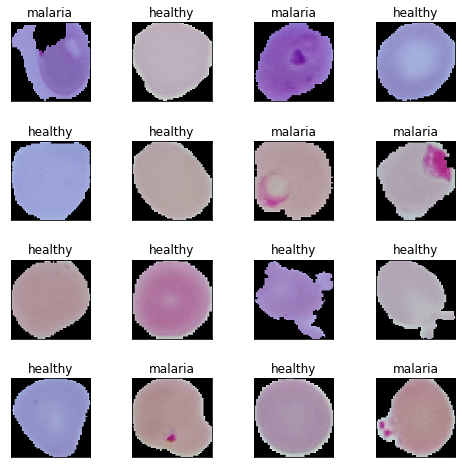

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [7]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'healthy' 'malaria' 'malaria' 'healthy' 'healthy'] [1 0 1 1 0 0]


In [8]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

tf.random.set_seed(42)
tf.__version__

'2.1.0'

In [0]:
# Model 1: CNN from Scratch

In [10]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

In [11]:
import datetime

logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Train on 17360 samples, validate on 1929 samples
Epoch 1/25
17360/17360 [==============================] - 16s 899us/sample - loss: 0.3782 - accuracy: 0.8234 - val_loss: 0.1950 - val_accuracy: 0.9357
Epoch 2/25
17360/17360 [==============================] - 9s 493us/sample - loss: 0.1590 - accuracy: 0.9505 - val_loss: 0.1819 - val_accuracy: 0.9450
Epoch 3/25
17360/17360 [==============================] - 9s 493us/sample - loss: 0.1282 - accuracy: 0.9586 - val_loss: 0.1645 - val_accuracy: 0.9508
Epoch 4/25
17360/17360 [==============================] - 9s 491us/sample - loss: 0.1173 - accuracy: 0.9611 - val_loss: 0.1534 - val_accuracy: 0.9513
Epoch 5/25
17360/17360 [==============================] - 9s 493us/sample - loss: 0.0976 - accuracy: 0.9677 - val_loss: 0.1683 - val_accuracy: 0.9518
Epoch 6/25
17360/17360 [==============================] - 9s 492us/sample - loss: 0.0838 - accuracy: 0.9717 - val_loss: 0.1696 - val_accuracy: 0.9487
Epoch 7/25
17360/17360 [==========================

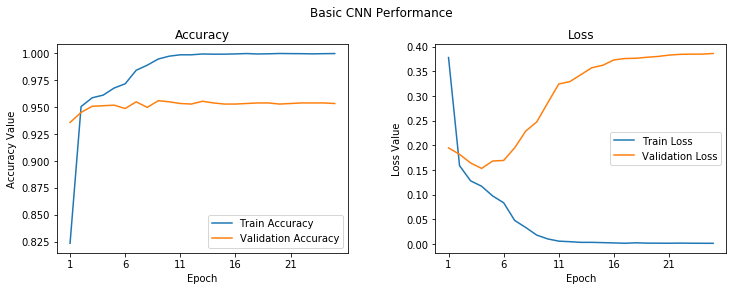

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('basic_cnn.h5')

In [0]:
# Transfer Learning
# Model 2: Frozen Pre-trained CNN

In [15]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
____________________________________________________________

In [16]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Train on 17360 samples, validate on 1929 samples
Epoch 1/25
17360/17360 [==============================] - 23s 1ms/sample - loss: 0.3932 - accuracy: 0.8182 - val_loss: 0.4444 - val_accuracy: 0.8103
Epoch 2/25
17360/17360 [==============================] - 21s 1ms/sample - loss: 0.2809 - accuracy: 0.8823 - val_loss: 0.2461 - val_accuracy: 0.9010
Epoch 3/25
17360/17360 [==============================] - 21s 1ms/sample - loss: 0.2496 - accuracy: 0.8980 - val_loss: 0.3177 - val_accuracy: 0.8725
Epoch 4/25
17360/17360 [==============================] - 21s 1ms/sample - loss: 0.2304 - accuracy: 0.9056 - val_loss: 0.2730 - val_accuracy: 0.8927
Epoch 5/25
17360/17360 [==============================] - 21s 1ms/sample - loss: 0.1919 - accuracy: 0.9259 - val_loss: 0.2132 - val_accuracy: 0.9145
Epoch 6/25
17360/17360 [==============================] - 21s 1ms/sample - loss: 0.1846 - accuracy: 0.9301 - val_loss: 0.2154 - val_accuracy: 0.9155
Epoch 7/25
17360/17360 [==============================] -

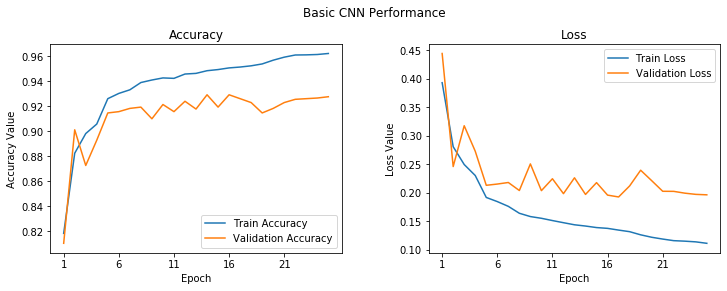

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('vgg_frozen.h5')

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


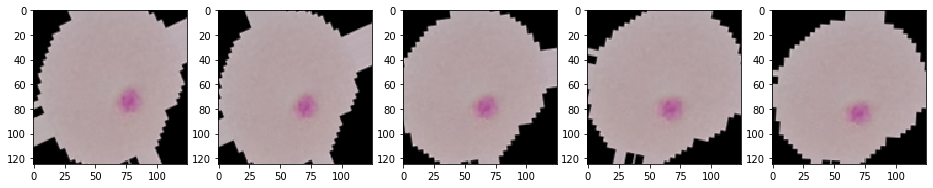

In [21]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [0]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

In [0]:

# Transfer Learning
# Model 3: Fine-tuned Pre-trained CNN with Image Augmentation

In [24]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


In [0]:
# Train Model

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/25
271/271 [==============================] - 70s 258ms/step - loss: 0.2241 - accuracy: 0.9079 - val_loss: 0.1590 - val_accuracy: 0.9505
Epoch 2/25
271/271 [==============================] - 68s 252ms/step - loss: 0.1343 - accuracy: 0.9548 - val_loss: 0.1762 - val_accuracy: 0.9453
Epoch 3/25
271/271 [==============================] - 68s 253ms/step - loss: 0.1213 - accuracy: 0.9588 - val_loss: 0.1448 - val_accuracy: 0.9573
Epoch 4/25
271/271 [==============================] - 69s 253ms/step - loss: 0.1141 - accuracy: 0.9615 - val_loss: 0.1378 - val_accuracy: 0.9531
Epoch 5/25
271/271 [==============================] - 68s 251ms/step - loss: 0.1079 - accuracy: 0.9633 - val_loss: 0.1278 - val_accuracy: 0.9542
Epoch 6/25
271/271 [==============================] - 68s 252ms/step - loss: 0.1033 - accuracy: 0.9646 - v

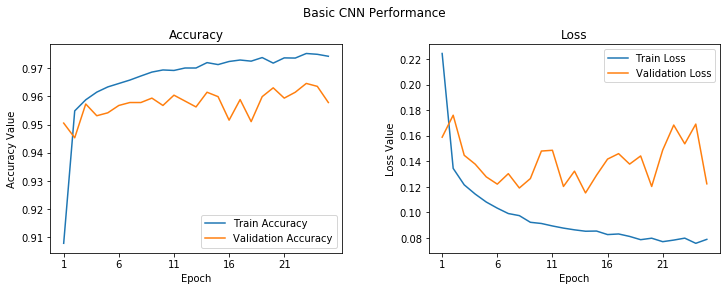

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('vgg_finetuned.h5')


In [29]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8268, 125, 125, 3), (8268,))

In [30]:
! ls -l --block-size=MB | grep .h5

-rw-r--r-- 1 root root 182MB Feb 26 18:30 basic_cnn.h5
-rw-r--r-- 1 root root 173MB Feb 26 19:11 vgg_finetuned.h5
-rw-r--r-- 1 root root 102MB Feb 26 18:40 vgg_frozen.h5


In [0]:

basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')
vgg_frz = tf.keras.models.load_model('./vgg_frozen.h5')
vgg_ft = tf.keras.models.load_model('./vgg_finetuned.h5')

In [0]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_frz_preds.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])

In [0]:

from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
                        

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)


def plot_model_decision_surface(clf, train_features, train_labels,
                                plot_step=0.02, cmap=plt.cm.RdYlBu,
                                markers=None, alphas=None, colors=None):
    
    if train_features.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = train_features[:, 0].min() - plot_step, train_features[:, 0].max() + plot_step
    y_min, y_max = train_features[:, 1].min() - plot_step, train_features[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf_est = clone(clf)
    clf_est.fit(train_features,train_labels)
    if hasattr(clf_est, 'predict_proba'):
        Z = clf_est.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf_est.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)
    
    le = LabelEncoder()
    y_enc = le.fit_transform(train_labels)
    n_classes = len(le.classes_)
    plot_colors = ''.join(colors) if colors else [None] * n_classes
    label_names = le.classes_
    markers = markers if markers else [None] * n_classes
    alphas = alphas if alphas else [None] * n_classes
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y_enc == i)
        plt.scatter(train_features[idx, 0], train_features[idx, 1], c=color,
                    label=label_names[i], cmap=cmap, edgecolors='black', 
                    marker=markers[i], alpha=alphas[i])
    plt.legend()
    plt.show()


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
    y_test = label_binarize(true_labels, classes=class_labels)
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prob = clf.predict_proba(features)
            y_score = prob[:, prob.shape[1]-1] 
        elif hasattr(clf, 'decision_function'):
            prob = clf.decision_function(features)
            y_score = prob[:, prob.shape[1]-1]
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(y_test, y_score)      
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
                                 ''.format(roc_auc),
                 linewidth=2.5)
        
    elif n_classes > 2:
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"],
                 label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label='macro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_labels):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(label, roc_auc[i]), 
                     linewidth=2, linestyle=':')
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


In [51]:
basic_cnn_metrics = display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=basic_cnn_pred_labels, 
                                      classes=list(set(test_labels)))


Model Performance metrics:
------------------------------
Accuracy: 0.9516
Precision: 0.9517
Recall: 0.9516
F1 Score: 0.9516

Model Classification report:
------------------------------
              precision    recall  f1-score   support

     healthy       0.95      0.96      0.95      4144
     malaria       0.96      0.95      0.95      4124

    accuracy                           0.95      8268
   macro avg       0.95      0.95      0.95      8268
weighted avg       0.95      0.95      0.95      8268


Prediction Confusion Matrix:
------------------------------
                Predicted:        
                   healthy malaria
Actual: healthy       3964     180
        malaria        220    3904


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead


In [52]:
vgg_frz_metrics = display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=vgg_frz_pred_labels, 
                                      classes=list(set(test_labels)))


Model Performance metrics:
------------------------------
Accuracy: 0.9321
Precision: 0.9322
Recall: 0.9321
F1 Score: 0.9321

Model Classification report:
------------------------------
              precision    recall  f1-score   support

     healthy       0.93      0.93      0.93      4144
     malaria       0.93      0.93      0.93      4124

    accuracy                           0.93      8268
   macro avg       0.93      0.93      0.93      8268
weighted avg       0.93      0.93      0.93      8268


Prediction Confusion Matrix:
------------------------------
                Predicted:        
                   healthy malaria
Actual: healthy       3857     287
        malaria        274    3850


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead


In [53]:
vgg_ft_metrics = display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=vgg_ft_pred_labels, 
                                      classes=list(set(test_labels)))


Model Performance metrics:
------------------------------
Accuracy: 0.9624
Precision: 0.9629
Recall: 0.9624
F1 Score: 0.9624

Model Classification report:
------------------------------
              precision    recall  f1-score   support

     healthy       0.95      0.98      0.96      4144
     malaria       0.98      0.95      0.96      4124

    accuracy                           0.96      8268
   macro avg       0.96      0.96      0.96      8268
weighted avg       0.96      0.96      0.96      8268


Prediction Confusion Matrix:
------------------------------
                Predicted:        
                   healthy malaria
Actual: healthy       4059      85
        malaria        226    3898


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead


In [54]:

import pandas as pd

basic_cnn_metrics = get_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels)
vgg_frz_metrics = get_metrics(true_labels=test_labels, predicted_labels=vgg_frz_pred_labels)
vgg_ft_metrics = get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels)

pd.DataFrame([basic_cnn_metrics, vgg_frz_metrics, vgg_ft_metrics], 
             index=['Basic CNN', 'VGG-19 Frozen', 'VGG-19 Fine-tuned'])

Accuracy: 0.9516
Precision: 0.9517
Recall: 0.9516
F1 Score: 0.9516
Accuracy: 0.9321
Precision: 0.9322
Recall: 0.9321
F1 Score: 0.9321
Accuracy: 0.9624
Precision: 0.9629
Recall: 0.9624
F1 Score: 0.9624


,0
Basic CNN,None
VGG-19 Frozen,None
VGG-19 Fine-tuned,None
